### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [2]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [9]:
from help_funcs import * 
import xarray as xr
import pandas as pd
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gc
import os 
from os.path import exists
import dask_labextension

In [ ]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=4)
from dask.distributed import Client
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.91:34935,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
results_tcvw = natsorted(str(result) for result in list(Path("/vortexfs1/share/cdx/hseo/Data/ERA5/NEP/tcwv").rglob("*.[nN][cC]")))
results_tp = natsorted([str(result) for result in list(Path("/vortexfs1/share/cdx/hseo/Data/ERA5/NEP/tp").rglob("*.[nN][cC]"))])
results_z500 = natsorted([str(result) for result in list(Path("/vortexfs1/share/cdx/hseo/Data/ERA5/NEP/z500").rglob("*.[nN][cC]"))])

In [6]:
def _preprocess_ERA5(ds):
    return ds.sel(latitude = slice(60, -2)).sel(longitude = slice(-150, -75)).resample(time="1D").mean().sel(time = slice("1993", None))

open_mfdataset = lambda x: xr.open_mfdataset(x,concat_dim="time", combine="nested", 
        data_vars="minimal", coords="minimal",
        compat="override", preprocess=_preprocess_ERA5,
        parallel=True, chunks={"latitude":-1, "longitude":-1, "time":-1}, engine="netcdf4")

ds_tcwv = open_mfdataset(results_tcvw)
ds_tp = open_mfdataset(results_tp)
ds_z500 = open_mfdataset(results_z500)
ds_tp = (24e3) * ds_tp #m/hour -> mm/ day 
#resample hourly data to daily. Total precipiation requires of a change of units by a factor of (1000 * 24)
era5_daily = xr.merge([ds_tcwv, ds_tp, ds_z500])
#save the dataset before processing 
era5_daily.to_netcdf(GLORYS_data_dir("ERA5_NE_PAC_daily.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)

In [7]:
#reopen daily fields that have been saved in a nicer format and save the anomalies
gc.collect()
era5_daily = xr.open_mfdataset(GLORYS_data_dir("ERA5_NE_PAC_daily.nc"), 
                                data_vars="minimal",
                                coords="minimal",
                                compat="override",
                                parallel=True,
                                chunks={"longitude": -1, "latitude":-1, "time":100},
                                engine="netcdf4")

In [8]:
era5_daily = era5_daily.convert_calendar('noleap') #remove leap years from operations
era5_climatology = era5_daily.groupby("time.dayofyear").mean("time")
era5_climatology.to_netcdf(ERA5_data_dir("ERA5_Daily_Climatology.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)

In [4]:
era5_climatology = xr.open_dataset(ERA5_data_dir("ERA5_Daily_Climatology.nc"))

In [ ]:
era5_climatology = smooth_daily_climatology(era5_climatology)

tcwv
tp
z


In [21]:
era5_climatology.to_netcdf(ERA5_data_dir("ERA5_Daily_SmoothClimatology.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)

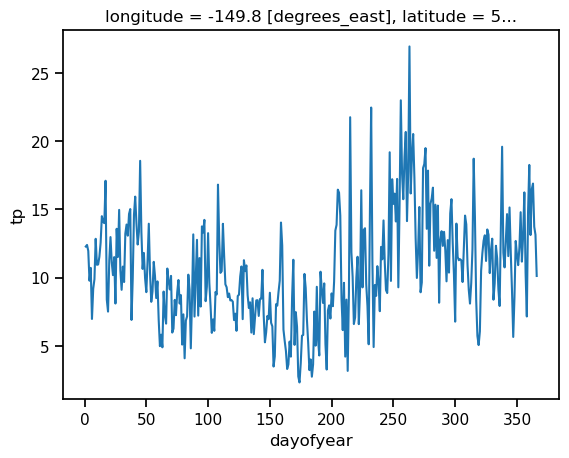

In [20]:
#check that the data was not corrupted
ds_climatology.tp[:, 1, 1].plot()